# Lattice 2D

In [1]:
%matplotlib inline
#
from LRGSG_package.LRGSG import *
from LRGSG_package.LRGSG_plots import imshow_colorbar_caxdivider
from LRGSG_package.LRGSG_utils import move_to_rootf, width_interval
from LRGSG_package.nx_patches import signed_spectral_layout, signedlaplacian_spectrum
#
move_to_rootf(print_tf=True)

cwd: /home/opisthofulax/PhD/projects/complex-networks/LRG-Signed


### Singularity scaling

In [9]:
lattices = {}
eigs = {}
sizes = [16, 32, 64, 128]
for side in sizes:
    lattices[side] = Lattice2D(#
        side1 = side,
        geometry = 'squared',
    )
    lattice = lattices[side]
    #
    lattice.init_weights()
    midway = lattices[side].N//2+lattices[side].side1//2
    neg_weightsH_cross = {
                    (midway, midway + lattices[side].side1): -1,
                    (midway-lattices[side].side1, midway): -1,
                    (midway-1, midway): -1,
                    (midway, midway+1): -1
                    # (midway+ lattices[side].side1, midway+ lattices[side].side1+1): -1,
                    # (midway, midway+ lattices[side].side1): -1,
                    # (midway+ 1, midway+ lattices[side].side1+1): -1,
                    }
    neg_weightsH = {(midway, midway+1): -1}
    lattice.flip_sel_edges(neg_weightsH, 'H')
    lattice.compute_k_eigvV()
    eigs[side] = lattice.eigV[0].reshape(lattice.syshape)

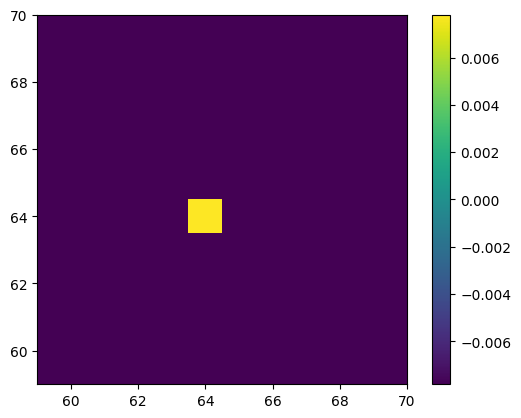

In [3]:
plt.imshow(eigs[sizes[-1]])
plt.ylim(sizes[-1]//2-5, sizes[-1]//2+6)
plt.xlim(sizes[-1]//2-5, sizes[-1]//2+6)
plt.colorbar()

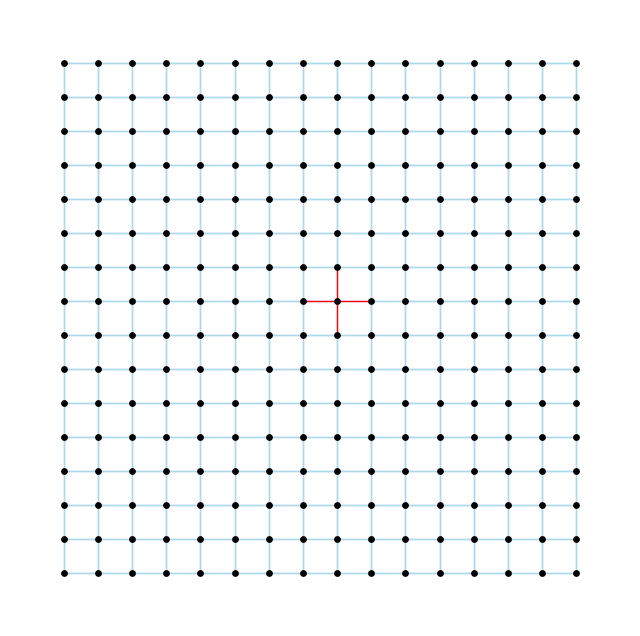

In [4]:
G = lattices[16].G
G_edges_ww = G.edges(data='weight')
edgecol = ['lightblue' if e[2] > 0 else 'r' for e in G_edges_ww]

fig, ax = plt.subplots(figsize=(8, 8))
nx.draw(G, 
        pos=lattices[16].posG, 
        ax=ax,  
        edge_color=edgecol, 
        node_color='k',  
        node_size=15,
        with_labels=False)

/tmp/ipykernel_5150/2968657585.py:5: RuntimeWarning: divide by zero encountered in log
  phi_plot = np.log(np.max(eigen_state) - eigen_state)


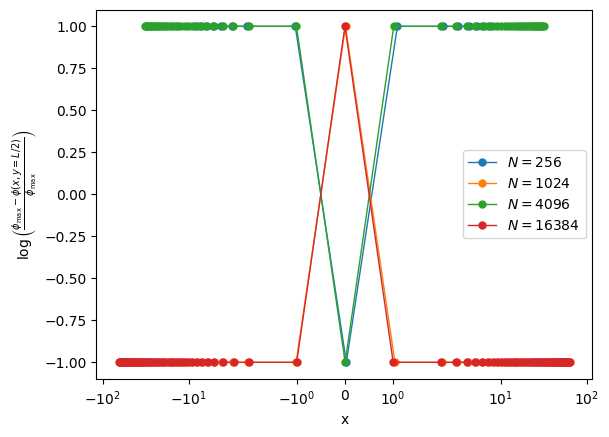

In [7]:
fig, ax = plt.subplots()

for side in sizes:
    eigen_state = eigs[side]
    phi_plot = np.log(np.max(eigen_state) - eigen_state)
    phi_plot = inf_array_regularization(phi_plot)
    #
    halfsize = lattices[side].side1//2
    cut = eigen_state[halfsize, :]
    x = np.linspace(0, len(cut), num=len(cut))-halfsize-.5
    y = cut/np.max(cut)
    ax.plot(x, y, 'o-',lw=1, markersize=5, label=fr"$N={side**2}$")

ax.set_ylabel(r'$\log\left(\frac{\phi_\max-\phi(x, y=L/2)}{\phi_\max}\right)$')
ax.set_xlabel('x')
ax.legend()
# ax.set_yscale('log')
# ax.axvline(-1, ls='--', c='k')
# ax.axvline(1, ls='--', c='k')
ax.set_xscale('symlog') 
# axins = ax.inset_axes(
#     [0.75, 0.3, 0.2, 0.4],
#     xlim=(-10, 10), ylim=(0.98, 1.5), xticklabels=[], yticklabels=[])

# for side in sizes:
#     eigen_state = np.abs(eigs[side])
#     phi_plot = np.log((np.max(eigen_state) - eigen_state)/np.max(eigen_state))
#     phi_plot_nnans = phi_plot[(phi_plot != np.inf) & (phi_plot != -np.inf)]
#     phi_plot = np.nan_to_num(phi_plot, posinf=np.max(phi_plot_nnans), neginf=np.min(phi_plot_nnans))
#     #
#     halfsize = lattices[side].side1//2
#     cut = phi_plot[:, halfsize]
#     x = np.linspace(0, len(cut), num=len(cut))-halfsize
#     axins.plot(x-0.5, cut/np.max(cut), 'o-',lw=1, markersize=5, label=fr"$N={side**2}$")

# for aax in [ax, axins]:
#     aax.axvline(-1, ls='--', c='k')
#     aax.axvline(1, ls='--', c='k')
# axins.set_xscale('symlog') 
# ax.indicate_inset_zoom(axins, edgecolor="black")
# 

- fai per triangolare
- sottrai magn e v_0, effetto di bordo
- vedi con FBC


Text(0.5, 1.0, '$v_0$')

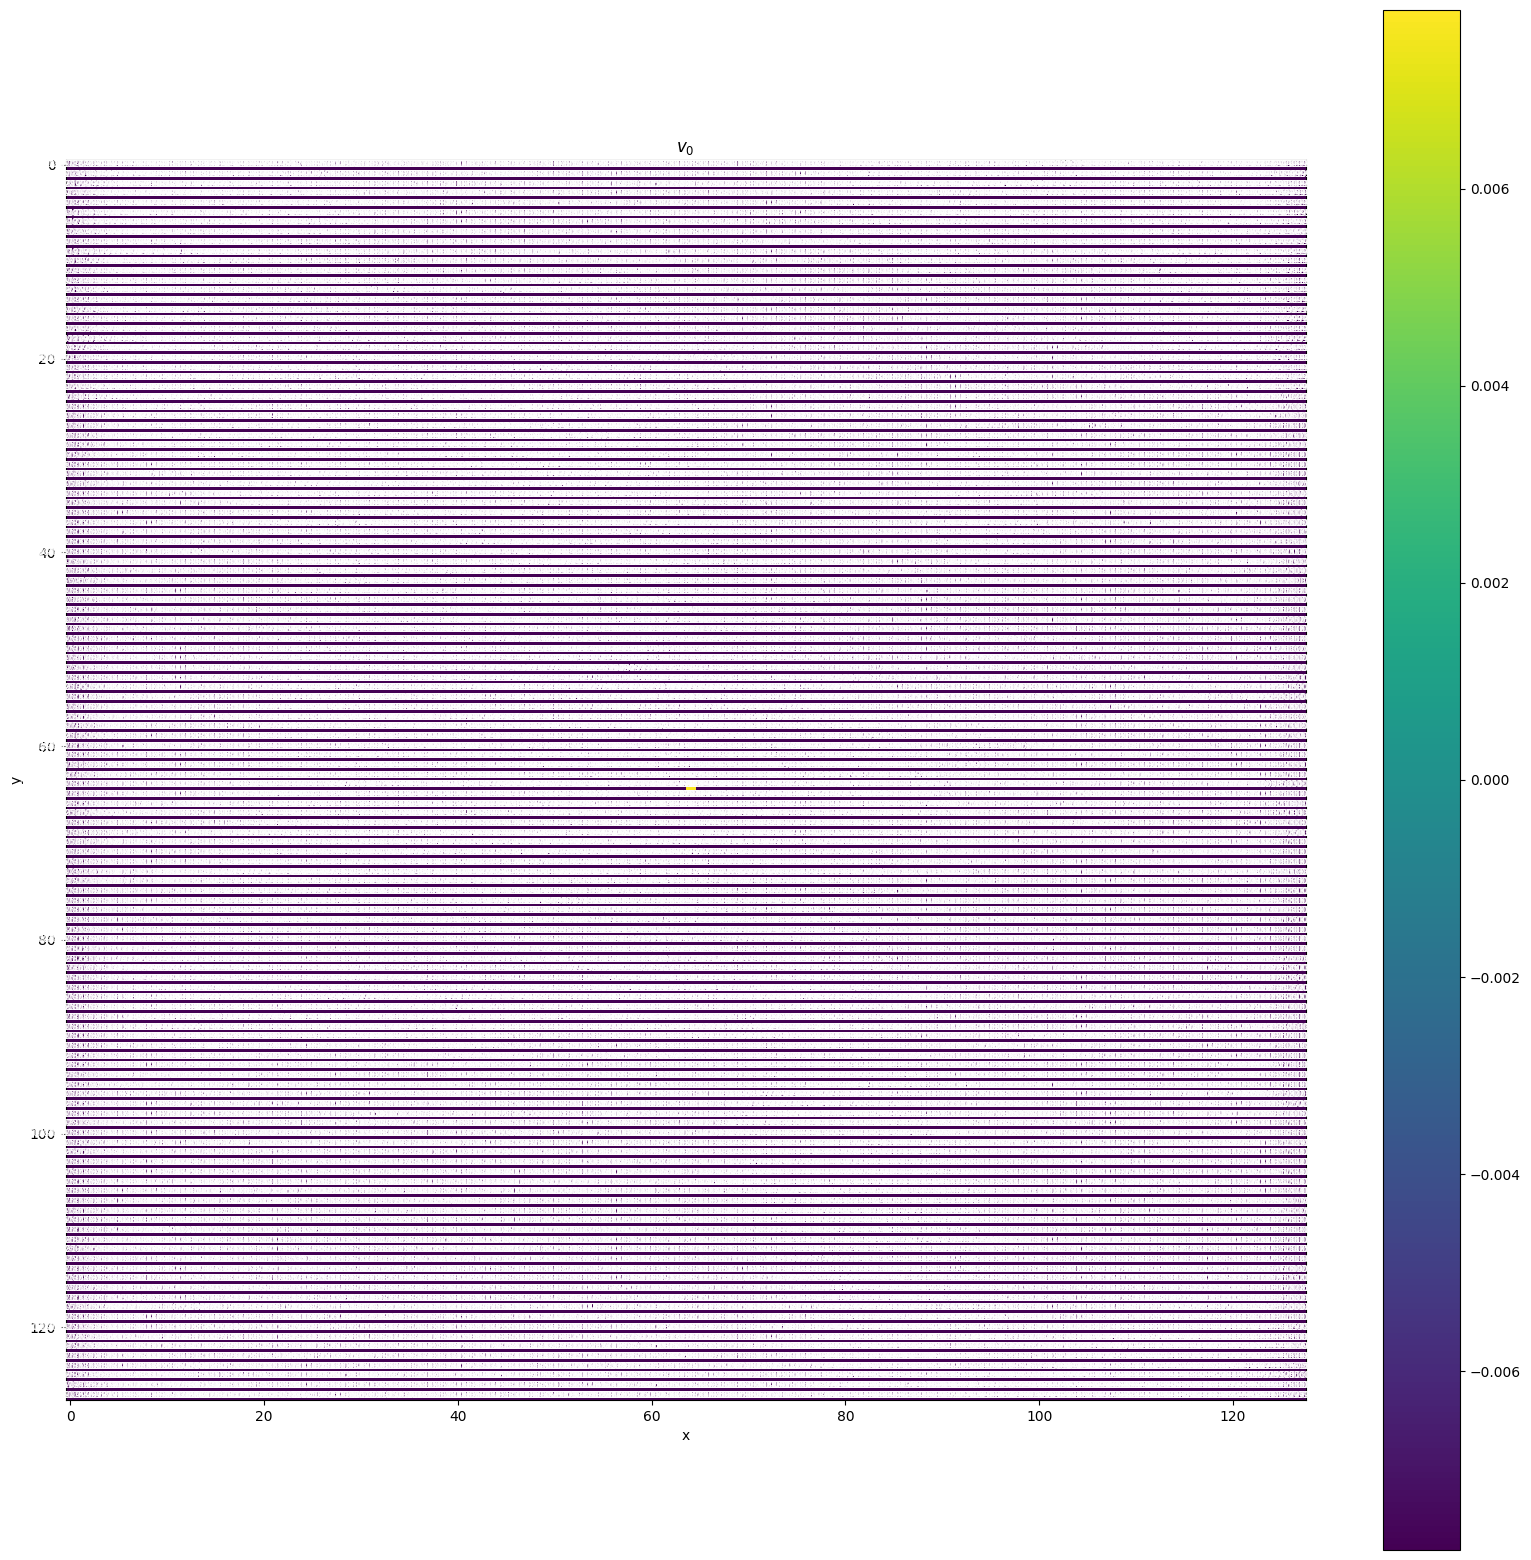

In [8]:
plt.figure(figsize=(20, 20))
plt.imshow(eigen_state)

for (j,i),label in np.ndenumerate(eigen_state):
    plt.text(i,j,label,ha='center',va='center', fontdict={'size':6, 'color': 'white'})

plt.colorbar()
plt.xlabel('x')
plt.ylabel('y')
plt.title('$v_0$')

In [4]:
side = 100
eigenmode = 0
#
theLattice1 = Lattice2D(#
    side1 = side,
    geometry = 'squared',
)
SLRG_obj1 = SignedLaplacianAnalysis(#
    system = theLattice1,
    initCond = 'all_1', # f'ground_state_{eigenmode}'
    t_steps = 10,
    no_obs = 200
)
theLattice.init_weights()
#
# neg_weightsG = {((i, j), (i, j+1)): -1 for i in range(SLRG_obj.system.side1) 
#                 for j in [SLRG_obj.system.side2//3, SLRG_obj.system.side2//2]}
neg_weightsH = {(SLRG_obj1.system.N//2+SLRG_obj1.system.side1//2, 
                 (SLRG_obj1.system.N)//2+SLRG_obj1.system.side1//2+1): -1,}
                #  (SLRG_obj.system.N//2+SLRG_obj.system.side1//3, 
                #  (SLRG_obj.system.N)//2+SLRG_obj.system.side1//3+1): -1, 
                #  (SLRG_obj.system.N//2+2*SLRG_obj.system.side1//3, 
                #  (SLRG_obj.system.N)//2+2*SLRG_obj.system.side1//3+1): -1}
theLattice1.flip_sel_edges(neg_weightsH, 'H')
#
# edges_to_flip = [(0, 1), (0, 2), (0, 3), (2, 5), (1, 12)]
# neg_weights = {e: -1 for e in edges_to_flip}
# SLRG_obj.flip_sel_edges(neg_weights)
#
# theLattice.flip_random_fract_edges()
#
theLattice1.compute_k_eigvV()
theLattice1.rescaled_signed_laplacian()

In [5]:
# SLRG_obj.laplacian_dynamics_init(
#     # window_size=1, 
#     # window_shift_y=0,
#     # window_shift_x=0,
#     # win_val=-1
# )

In [6]:
# fixed periodic sopra spin glass
# without rescaling
# prova a vedere se il numero di nodi che riesci a toccare quando 
# la matrice di adiacenza e riempita a 0.103 scala con N
# prendi il cammino piu lungo che riesci a fare

In [7]:



eigen_state1 = SLRG_obj1.system.eigV[eigenmode].reshape(SLRG_obj1.system.syshape)
phi_plot1 = np.log(np.max(eigen_state1)-eigen_state1)
phi_plot_nnans1 = phi_plot1[(phi_plot1 != np.inf) & (phi_plot1 != -np.inf)]
phi_plot1 = np.nan_to_num(phi_plot1, posinf=np.max(phi_plot_nnans1), neginf=np.min(phi_plot_nnans1))

/tmp/ipykernel_41865/639744242.py:2: RuntimeWarning: divide by zero encountered in log
  phi_plot1 = np.log(np.max(eigen_state1)-eigen_state1)


Text(0.5, 0, 'x')

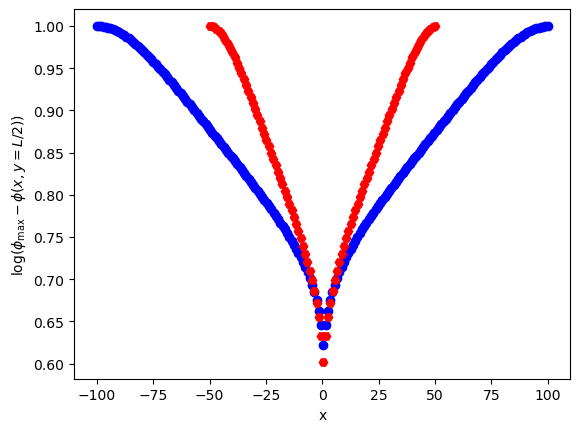

In [17]:


halfsize = SLRG_obj.system.side1//2
halfsize1 = SLRG_obj1.system.side1//2
# hcut_halfsize = phi_plot[halfsize, :]
# vcut_halfsize = phi_plot[:, halfsize]
critrad = np.sqrt(1.128/(np.pi*0.103))
ball_halfsizeM = halfsize+1-critrad
ball_halfsizeP = halfsize+1+critrad

fig, ax = plt.subplots()

cut = phi_plot[:, halfsize]
cut1 = phi_plot1[:, halfsize1]
cutstart = len(cut)//2+20
cutend = cutstart+50

cutcut = cut[cutstart:cutend]
x = np.linspace(cutstart, cutend, num=len(cutcut))-theLattice.side1//2
x2 = np.linspace(0, len(cut), num=len(cut))-theLattice.side1//2
ax.plot(x2, cut/np.min(cut), 'bo')
x2 = np.linspace(0, len(cut1), num=len(cut1))-theLattice1.side1//2
ax.plot(x2, cut1/np.min(cut1), 'rH')
# ax.plot(x, cutcut, 'ro')
params, cov = curve_fit(line, x, cutcut)
# ax.plot(x, line(x, *params))

ax.set_ylabel(r'$\log(\phi_\max-\phi(x, y=L/2))$')
ax.set_xlabel('x')
# plt.xscale('symlog')
# xx = np.linspace(0, SLRG_obj.system.side1//2)
# ax.plot(xx+50, line(xx, *params))
# plt.yscale('log')

In [28]:
initial_state = SLRG_obj.field.reshape(SLRG_obj.system.syshape)
SLRG_obj.run_laplacian_dynamics(
    rescaled=False,
    saveFrames=True)
final_state = SLRG_obj.field.reshape(SLRG_obj.system.syshape)

Beginning Laplacian dynamics.


 22%|██▏       | 87953/399999 [01:00<03:33, 1459.29it/s]


KeyboardInterrupt: 

In [ ]:
# fisso stato stazionario come una costante, al variare della taglia
# verifica matrice di jordan a blocchi


In [ ]:
# eigv, eigV = scsp.linalg.eigsh(SLRG_obj.system.resLp, k=1, which='SM') 
# plt.imshow((eigV.reshape(SLRG_obj.system.syshape)), cmap='hot_r')
# plt.colorbar()

In [ ]:
final_state = SLRG_obj.field.reshape(SLRG_obj.system.syshape)

In [11]:
if np.mean(initial_state)*np.mean(eigen_state) < 0:
    eigen_state = -eigen_state
#
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
#
im1 = axs[0].imshow(initial_state, cmap='hot')
_ = imshow_colorbar_caxdivider(im1, axs[0])
axs[0].set_title(r'$X(0)$')
#
im2 = axs[1].imshow(final_state, cmap='hot')
_ = imshow_colorbar_caxdivider(im2, axs[1])
axs[1].set_title(r'$X(\infty)$')
#
im3 = axs[2].imshow(eigen_state, cmap='hot')
_ = imshow_colorbar_caxdivider(im3, axs[2])
axs[2].set_title(r'$\vec{v}_0$')
#
cpflip = SLRG_obj.system.Ne_n/SLRG_obj.system.Ne
fig.suptitle(fr'$N={SLRG_obj.system.N}, p={cpflip:.3g}$', fontsize=25)
fig.tight_layout()

NameError: name 'initial_state' is not defined

In [ ]:
phi_plot = np.log(np.max(eigen_state)-eigen_state)
phi_plot_nnans = phi_plot[(phi_plot != np.inf) & (phi_plot != -np.inf)]
phi_plot = np.nan_to_num(phi_plot, posinf=np.max(phi_plot_nnans), neginf=np.min(phi_plot_nnans))

/tmp/ipykernel_40930/2187982115.py:1: RuntimeWarning: divide by zero encountered in log
  phi_plot = np.log(np.max(eigen_state)-eigen_state)


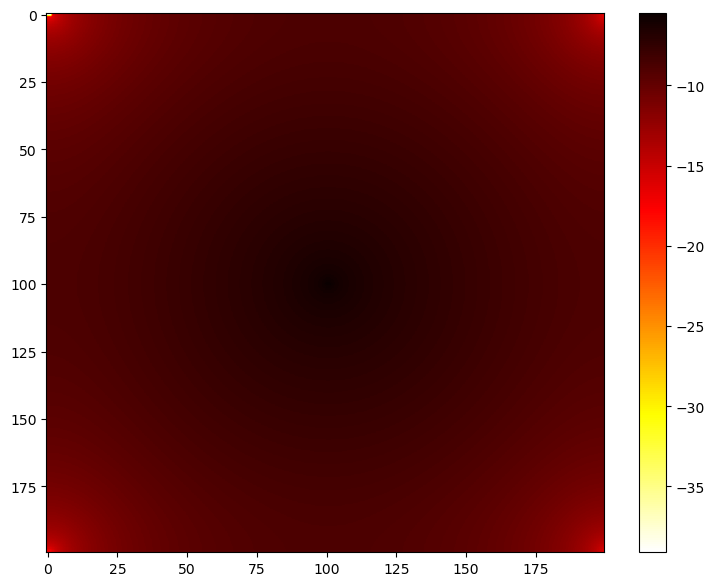

In [12]:
fig, ax1 = plt.subplots(figsize=(9, 7))
im1 = ax1.imshow(phi_plot, cmap=plt.cm.hot_r, aspect="auto")
plt.colorbar(im1)

In [ ]:
halfsize = SLRG_obj.system.side1//2
hcut_halfsize = phi_plot[halfsize, :]
vcut_halfsize = phi_plot[:, halfsize]
critrad = np.sqrt(1.128/(np.pi*0.103))
ball_halfsizeM = halfsize+1-critrad
ball_halfsizeP = halfsize+1+critrad

In [ ]:
from scipy.optimize import curve_fit
from LRGSG_package.LRGSG_utils import line

# phi_asym = hcut_halfsize[SLRG_obj.system.side1//2:]
# x = np.linspace(0, len(phi_asym), num=len(phi_asym))

# idx = 5
# params, cov = curve_fit(line, x[:idx], phi_asym[:idx])
# ax.plot(x, line(x, *params))


Text(0.5, 0, 'x')

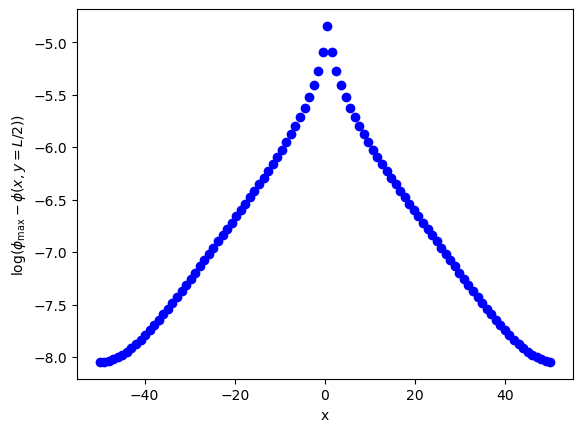

In [ ]:
fig, ax = plt.subplots()

cut = phi_plot[:, halfsize]
cutstart = len(cut)//2+20
cutend = cutstart+50

cutcut = cut[cutstart:cutend]
x = np.linspace(cutstart, cutend, num=len(cutcut))-theLattice.side1//2
x2 = np.linspace(0, len(cut), num=len(cut))-theLattice.side1//2
ax.plot(x2, cut, 'bo')
# ax.plot(x, cutcut, 'ro')
params, cov = curve_fit(line, x, cutcut)
# ax.plot(x, line(x, *params))

ax.set_ylabel(r'$\log(\phi_\max-\phi(x, y=L/2))$')
ax.set_xlabel('x')
# plt.xscale('symlog')
# xx = np.linspace(0, SLRG_obj.system.side1//2)
# ax.plot(xx+50, line(xx, *params))
# plt.yscale('log')

In [13]:
-1/params[0]

37.517988386008696

Text(0, 0.5, '$r_{\\rm c}$')

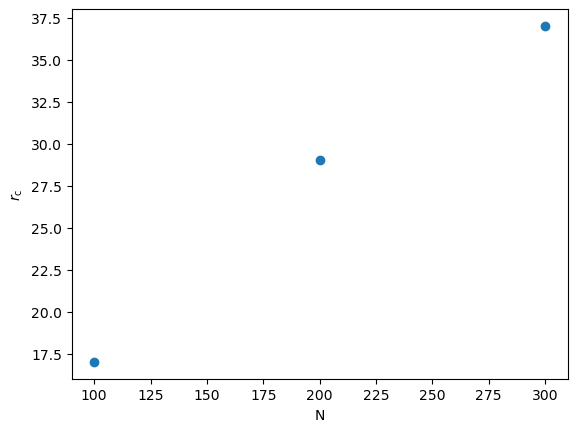

In [17]:
plt.plot([100, 200, 300], [17, 29, 37], 'o')
plt.xlabel('N')
plt.ylabel(r'$r_{\rm c}$')